## Dirichlet Process Mixture Models

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
from pyro.distributions import *
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.optim import Adam

assert pyro.__version__.startswith('1.8.1')
pyro.set_rng_seed(0)

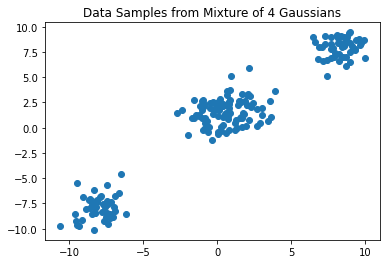

In [2]:
#create data

data = torch.cat((MultivariateNormal(-8 * torch.ones(2), torch.eye(2)).sample([50]),
                  MultivariateNormal(8 * torch.ones(2), torch.eye(2)).sample([50]),
                  MultivariateNormal(torch.tensor([1.5, 2]), torch.eye(2)).sample([50]),
                  MultivariateNormal(torch.tensor([-0.5, 1]), torch.eye(2)).sample([50])))

plt.scatter(data[:, 0], data[:, 1])
plt.title("Data Samples from Mixture of 4 Gaussians")
plt.show()
N = data.shape[0]

In [3]:
# stick-breaking function that generates our weights 
def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

In [87]:
def model(data):
    with pyro.plate("beta_plate", T-1):
        beta = pyro.sample("beta", Beta(1, alpha)) # beta_i samples are conditionally independent

    with pyro.plate("mu_plate", T):
        mu = pyro.sample("mu", MultivariateNormal(torch.zeros(2), 5 * torch.eye(2)))

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(mix_weights(beta))) # Categorical distribution whose parameters are the mixture weights using our sampled beta values
        # Finally, we sample our observations from a multivariate Gaussian distribution 
        # whose mean is exactly the cluster parameter corresponding to the assignment z_n we drew for the point x_n 
        pyro.sample("obs", MultivariateNormal(mu[z], torch.eye(2)), obs=data)

def guide(data):
    kappa = pyro.param('kappa', lambda: Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
    tau = pyro.param('tau', lambda: torch.rand(T,2))
    phi = pyro.param('phi', lambda: Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)

    #
    
    sigma =  pyro.param('sigma', lambda: torch.rand(1))
    l = pyro.sample("l",  dist.LKJCholesky(2, sigma))

    with pyro.plate("beta_plate", T-1):
        q_beta = pyro.sample("beta", Beta(torch.ones(T-1), kappa))

    with pyro.plate("mu_plate", T):
        q_mu = pyro.sample("mu", MultivariateNormal(tau, scale_tril=sigma*l))

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(phi)) 

In [19]:
d = 3
options = dict(dtype=data.dtype, device=data.device)

concentration = torch.ones(
        (), **options
    ) 
dist.LKJCholesky(T,2, concentration).sample([1])
concentration

tensor(1.)

In [78]:
torch.rand(6)*dist.LKJCholesky(2, 1.).sample([1])

RuntimeError: The size of tensor a (6) must match the size of tensor b (2) at non-singleton dimension 2

In [88]:
T = 6
optim = Adam({"lr": 0.05})
svi = SVI(model, guide, optim, loss=Trace_ELBO())
losses = []

def train(num_iterations):
    pyro.clear_param_store()
    for j in tqdm(range(num_iterations)):
        loss = svi.step(data)
        losses.append(loss)

def truncate(alpha, centers, weights):
    threshold = alpha**-1 / 100.
    true_centers = centers[weights > threshold] # remove clusters which have a too small probability
    true_weights = weights[weights > threshold] / torch.sum(weights[weights > threshold]) # re-normalize weights so that they sum to one
    
    idx_kept = torch.topk(weights, true_centers.shape[0])[1]
    return true_centers, true_weights, idx_kept
    
alpha = 0.1
train(1000)

  0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\Erika\AppData\Local\R-MINI~1\envs\deep-learn\lib\site-packages\pyro\util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'l'}
  warnings.warn(
 42%|████▏     | 418/1000 [00:11<00:15, 36.40it/s]


ValueError: Expected parameter concentration (Tensor of shape (1, 2, 2)) of distribution Dirichlet(concentration: torch.Size([1, 2, 2])) to satisfy the constraint IndependentConstraint(GreaterThan(lower_bound=0.0), 1), but found invalid values:
tensor([[[ 0.5000, -0.0887],
         [ 0.5000, -0.0887]]], grad_fn=<StackBackward0>)
Trace Shapes:      
 Param Sites:      
        kappa     5
          tau   6 2
          phi 200 6
        sigma     1
Sample Sites:      

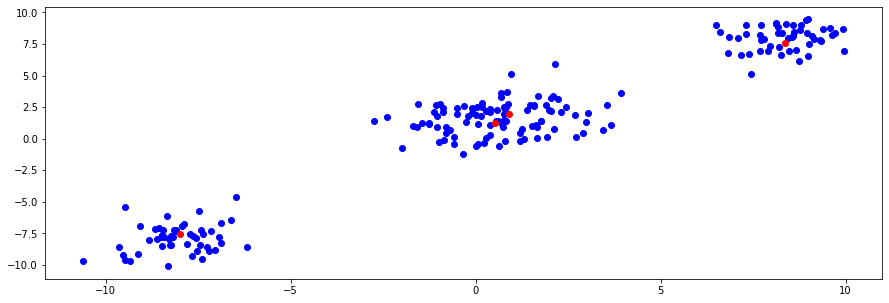

In [92]:
# We make a point-estimate of our model parameters using the posterior means of tau and phi for the centers and weights
Bayes_Centers_01, Bayes_Weights_01, idx_kept = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))

plt.figure(figsize=(15, 5))
plt.scatter(data[:, 0], data[:, 1], color="blue")
plt.scatter(Bayes_Centers_01[:, 0], Bayes_Centers_01[:, 1], color="red")

plt.show()

In [49]:
# extract posterior for beta and z
posterior = Predictive(guide, num_samples=len(data), return_sites=["beta","z"])(data)
post_pred_weights = mix_weights(posterior["beta"])
post_pred_clusters = posterior["z"]

In [93]:
# reassign clusters from those kept by truncate function
assignment = [torch.argmax(i) for i in pyro.param("phi").detach()[:,[list(idx_kept)]]]

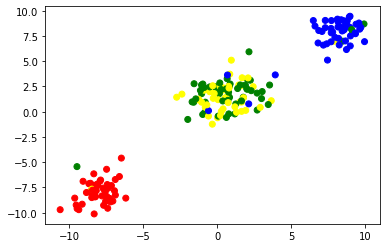

In [94]:
# visualize colored clusters
col = ["red","blue","green","yellow","pink","black"]
clusts = []
for idx,p in enumerate(data):
    clusts.append(col[assignment[idx]])

plt.scatter(data[:, 0], data[:, 1], color=clusts)